# 引用库

In [ ]:
#引用需要用到的库
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as image
import cv2
import os

# 调用GPU

In [2]:
#调用GPU
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.empty_cache()

cuda


# 初始化变量

In [3]:
#初始变量
n_epochs = 100 #训练3个epoch
batch_size_train = 120 #训练的 batch_size
batch_size_test = 1000 #测试的 batch_size
learning_rate = 0.001 # 学习率
momentum = 0.5 # 在梯度下降过程中解决mini-batch SGD优化算法更新幅度摆动大的问题，使得收敛速度更快
log_interval = 10 # 操作间隔
random_seed = 2 # 随机种子，设置后可以得到稳定的随机数
torch.manual_seed(random_seed)

# 导入训练集并增强数据

In [ ]:
#导入训练集并增强数据
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./mnist/', train=True, download=False,
                               transform=torchvision.transforms.Compose([
                                   #torchvision.transforms.Resize(120),
                                   torchvision.transforms.RandomAffine(degrees =0,translate=(0.1, 0.1)),
                                   torchvision.transforms.RandomRotation((-10,10)),#将图片随机旋转（-10,10）度
                                   torchvision.transforms.ToTensor(),# 将PIL图片或者numpy.ndarray转成Tensor类型
                                   torchvision.transforms.Normalize((0.1307,), (0.3081,))])
                              ),
    batch_size=batch_size_train, shuffle=True,num_workers=4, pin_memory=True) # shuffle如果为true,每个训练epoch后，会将数据顺序打乱

# 导入测试集

In [5]:
#导入测试集
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./mnist/', train=False, download=False,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize((0.1307,), (0.3081,))])
                              ),
    batch_size=batch_size_test, shuffle=True,num_workers=4, pin_memory=True)

In [6]:
# 训练数据 60000 张图像；测试数据 10000张图像
print(train_loader.dataset)
print(test_loader.dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1))
               RandomRotation(degrees=[-10.0, 10.0], resample=False, expand=False)
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./mnist/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


In [71]:
# 用 enumerate 加载测试集
examples = enumerate(test_loader)
# 获取一个 batch
batch_idx, (example_data, example_targets) = next(examples)
# 查看 batch 数据，有10000张图像的标签，tensor 大小为 [1000, 1, 28, 28]
# 即图像为 28 * 28， 1个颜色通道（灰度图）， 1000张图像
print(example_targets)
print(example_data.shape)

tensor([8, 8, 0, 8, 9, 8, 1, 0, 6, 9, 3, 1, 8, 3, 8, 2, 4, 6, 2, 9, 8, 2, 8, 7,
        1, 8, 3, 9, 5, 3, 3, 9, 7, 0, 4, 8, 0, 2, 4, 1, 4, 6, 2, 0, 6, 2, 3, 4,
        1, 2, 2, 4, 5, 5, 1, 0, 3, 1, 4, 4, 2, 9, 7, 7, 4, 1, 2, 9, 8, 8, 0, 6,
        3, 9, 8, 8, 0, 7, 4, 9, 8, 6, 9, 7, 7, 1, 2, 7, 4, 4, 5, 5, 2, 5, 1, 1,
        7, 5, 8, 6, 6, 0, 3, 2, 9, 1, 0, 1, 1, 9, 8, 6, 1, 1, 0, 3, 7, 1, 9, 9,
        5, 7, 0, 9, 5, 4, 6, 1, 8, 3, 0, 7, 7, 4, 0, 6, 2, 2, 6, 4, 6, 9, 6, 3,
        4, 3, 2, 3, 5, 4, 4, 1, 0, 2, 4, 4, 9, 4, 1, 0, 4, 4, 6, 6, 4, 3, 5, 2,
        5, 2, 9, 6, 3, 0, 6, 9, 6, 4, 3, 8, 1, 3, 5, 5, 0, 4, 1, 1, 9, 0, 0, 4,
        8, 9, 2, 0, 6, 5, 4, 0, 3, 2, 8, 2, 6, 6, 2, 2, 2, 9, 3, 6, 4, 4, 3, 7,
        3, 3, 6, 5, 4, 6, 3, 6, 9, 6, 5, 4, 8, 4, 0, 9, 1, 0, 6, 7, 6, 5, 7, 9,
        9, 6, 4, 3, 2, 7, 9, 5, 8, 5, 0, 8, 5, 9, 5, 2, 1, 6, 0, 8, 1, 3, 2, 2,
        5, 7, 7, 6, 5, 6, 8, 0, 7, 7, 4, 0, 3, 3, 5, 6, 0, 7, 1, 9, 6, 9, 2, 7,
        3, 6, 9, 9, 9, 6, 2, 4, 1, 3, 8,

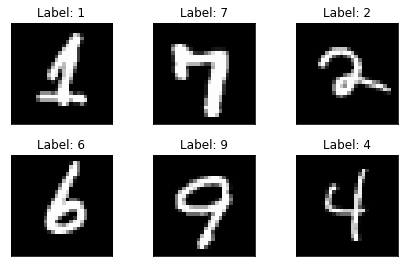

In [8]:
#查看部分图片
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)# 创建 subplot
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Label: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [73]:
example_data[1][0]

tensor([[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242

# model模型结构

In [10]:
#model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution layer 1
        self.conv1 = nn.Conv2d(in_channels = 1 , out_channels = 64, kernel_size = 5, stride = 1, padding = 2 )
        self.relu1 = nn.ReLU()
        self.batch1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(in_channels =64 , out_channels = 64, kernel_size = 5, stride = 1, padding = 2 )
        self.relu2 = nn.ReLU()
        self.batch2 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.drop1 = nn.Dropout(0.25)

        # Convolution layer 2
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1 )
        self.relu3 = nn.ReLU()
        self.batch3 = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1 )
        self.relu4 = nn.ReLU()
        self.batch4 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.drop2 = nn.Dropout(0.25)
        
        self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1 )
        self.relu5 = nn.ReLU()
        self.batch5 = nn.BatchNorm2d(64)
        self.drop3 = nn.Dropout(0.25)
        
        # Fully-Connected layer 1
        
        self.fc1 = nn.Linear(3136,256)
        self.fc1_relu = nn.ReLU()
        self.batch5 = nn.BatchNorm2d(64)
        self.dp1 = nn.Dropout(0.25)
        
        # Fully-Connected layer 2
        self.fc2 = nn.Linear(256,10)
        
        '''
        ###############################################
        # Reinitialize weights using He initialization
        ###############################################
        for m in self.modules():
             if isinstance(m, nn.Conv2d):
                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
             elif isinstance(m, nn.BatchNorm2d):
                 nn.init.constant_(m.weight, 1)
                 nn.init.constant_(m.bias, 0)
             elif isinstance(m, nn.Linear):
                 nn.init.xavier_normal_(m.weight)
                 nn.init.constant_(m.bias, 0)
        '''
                
    def forward(self, x):
        # conv layer 1 的前向计算，3行代码
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.batch1(out)
        
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.batch2(out)
        
        out = self.maxpool1(out)
        out = self.drop1(out)

        # conv layer 2 的前向计算，4行代码
        out = self.conv3(out)
        out = self.relu3(out)
        out = self.batch3(out)
        
        out = self.conv4(out)
        out = self.relu4(out)
        out = self.batch4(out)
        
        out = self.maxpool2(out)
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.relu5(out)
        out = self.batch5(out)
        out = self.drop3(out)

        #Flatten拉平操作
        out = out.view(out.size(0),-1)

        #FC layer的前向计算（2行代码）
        out = self.fc1(out)
        out = self.fc1_relu(out)
        out = self.dp1(out)
        
        out = self.fc2(out)

        return F.log_softmax(out,dim = 1)

# 权值初始化

In [11]:
#权值初始化
def weight_init(m):
    # 1. 根据网络层的不同定义不同的初始化方式  
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    '''
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    '''   

# 实例化网络并设置优化器

In [12]:
# 实例化一个网络
network = CNNModel()
network.to(device)
network.apply(weight_init)
# 设置优化器，用stochastic gradient descent，设置学习率，设置momentum
#optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
#optimizer = optim.Adam(network.parameters(), lr=learning_rate)
optimizer = optim.RMSprop(network.parameters(),lr=learning_rate,alpha=0.99,momentum = momentum)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True, threshold=0.000001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-10)

* torch.optim.lr_scheduler.ReduceLROnPlateau:该方法提供了一些基于训练过程中的某些测量值对学习率进行动态的下降.
* optimer指的是网络的优化器
* mode (str) ，可选择‘min’或者‘max’，min表示当监控量停止下降的时候，学习率将减小，max表示当监控量停止上升的时候，学习率将减小。默认值为‘min’
* factor 学习率每次降低多少，new_lr = old_lr * factor
* patience=10，容忍网路的性能不提升的次数，高于这个次数就降低学习率
* verbose（bool） - 如果为True，则为每次更新向stdout输出一条消息。 默认值：False
* threshold（float） - 测量新最佳值的阈值，仅关注重大变化。 默认值：1e-4
* cooldown： 减少lr后恢复正常操作之前要等待的时期数。 默认值：0。
*min_lr,学习率的下限
* eps ，适用于lr的最小衰减。 如果新旧lr之间的差异小于eps，则忽略更新。 默认值：1e-8。

# 查看模型的识别能力

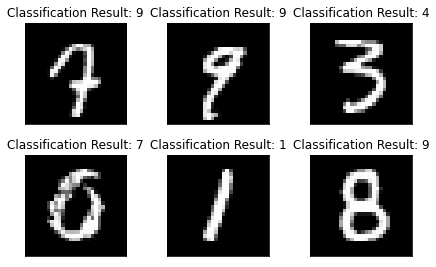

In [13]:
# 先看一下模型的识别能力
# 可以看到没有经过训练的模型在测试集上的表现是很差的，所有的图像几乎都识别错了
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    output = network(example_data.to(device))
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Classification Result: {}".format(
        output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
plt.show()

# 定义列表存储数据

In [14]:
#定义列表存储数据
train_losses = []
train_counter = []
train_acces = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
test_acces = []

# 定义训练函数

In [15]:
# 定义训练函数
def train(epoch):
    
    network.train() # 将网络设为 training 模式
    train_correct = 0
    # 对一组 batch 
    for batch_idx, (data, target) in enumerate(train_loader): 
        # 通过enumerate获取batch_id, data, and label
        # 1-将梯度归零
        optimizer.zero_grad()
        
        # 2-传入一个batch的图像，并前向计算
        output = network(data.to(device))
        
        # 3-计算损失
        loss = F.nll_loss(output, target.to(device))
        
        # 4-反向传播
        loss.backward()
        
        # 5-优化参数
        optimizer.step()
        #exp_lr_scheduler.step()
        
        
        train_pred = output.data.max(dim=1, keepdim=True)[1] # 取 output 里最大的那个类别, 
             # dim = 1表示去每行的最大值，[1]表示取最大值的index，而不去最大值本身[0]    

        train_correct += train_pred.eq(target.data.view_as(train_pred).to(device)).sum() # 比较并求正确分类的个数
        
        print('\r 第 {} 次 Train Epoch: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()),end = '')

        # 每第10个batch (log_interval = 10)
        if batch_idx  % log_interval == 0:
            #print(batch_idx)
            #打印以下信息：第几个epoch，第几张图像， 总训练图像数, 完成百分比，目前的loss
            '''print('\r 第 {} 次 Train Epoch: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()),end = '')
            '''
            # 把目前的 loss加入到 train_losses,后期画图用
            train_losses.append(loss.item())
            # 计数
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            '''
            # 每个batch训练完后保存模型 
            torch.save(network.state_dict(), './model.pth')

            # 每个batch训练完后保存优化器
            torch.save(optimizer.state_dict(), './optimizer.pth')
            '''
    
    train_acc = train_correct / len(train_loader.dataset)
    train_acces.append(train_acc.cpu().numpy().tolist())
    print('\tTrain Accuracy:{:.2f}%'.format(100. * train_acc))

# 定义测试函数

In [16]:
# 定义测试函数
def test(epoch):
    network.eval() # 将网络设为 evaluating 模式
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.to(device)) # 传入这一组 batch，进行前向计算
            #test_loss += F.nll_loss(output, target, size_average=False).item()
            test_loss += F.nll_loss(output, target.to(device), reduction='sum').item()

            pred = output.data.max(dim=1, keepdim=True)[1] # 取 output 里最大的那个类别, 
             # dim = 1表示去每行的最大值，[1]表示取最大值的index，而不去最大值本身[0]    

            correct += pred.eq(target.data.view_as(pred).to(device)).sum() # 比较并求正确分类的个数
    acc = correct / len(test_loader.dataset)
    test_acces.append(acc.cpu().numpy().tolist())
    
    test_loss /= len(test_loader.dataset) # 平均 loss， len 为 10000
    test_losses.append(test_loss) # 记录该 epoch 下的 test_loss
    
    if test_acces[-1] >= max(test_acces):
        # 每个batch训练完后保存模型 
        torch.save(network.state_dict(), './model03.pth')

        # 每个batch训练完后保存优化器
        torch.save(optimizer.state_dict(), './optimizer03.pth')
        
        torch.cuda.empty_cache()
    
    # 打印相关信息 如：Test set: Avg. loss: 2.3129, Accuracy: 1205/10000 (12%)
    '''
    print('\rTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)),end = '')
    '''
    print('\r Test set \033[1;31m{}\033[0m : Avg. loss: {:.4f}, Accuracy: {}/{}  \033[1;31m({:.2f}%)\033[0m\n'\
          .format(epoch,test_loss, correct,len(test_loader.dataset),100. * acc),end = '') 

In [17]:
# 先看一下模型的识别能力，可以看到没有经过训练的模型在测试集上的表现是很差的，大概只有10%左右的正确识别率
test(1)

 Test set 1 : Avg. loss: 2.3024, Accuracy: 1013/10000  (10.13%)


# 训练模型

In [18]:
### 训练！！！ 并在每个epoch之后测试 ###
###################################################
# 根据epoch数正式训练并在每个epoch训练结束后测试
for epoch in range(1, n_epochs + 1):
    scheduler.step(test_acces[-1])
    train(epoch)
    test(epoch)
print('\n\033[1;31mThe network Max Avg Accuracy : {:.2f}%\033[0m'.format(100. * max(test_acces)))

 第 1 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.128292	Train Accuracy:91.00%
 Test set 1 : Avg. loss: 0.0482, Accuracy: 9853/10000  (98.53%)
 第 2 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.148180	Train Accuracy:97.03%
 Test set 2 : Avg. loss: 0.0305, Accuracy: 9906/10000  (99.06%)
 第 3 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.027762	Train Accuracy:97.58%
 Test set 3 : Avg. loss: 0.0276, Accuracy: 9922/10000  (99.22%)
 第 4 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.026813	Train Accuracy:97.88%
 Test set 4 : Avg. loss: 0.0259, Accuracy: 9929/10000  (99.29%)
 第 5 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.087106	Train Accuracy:98.13%
 Test set 5 : Avg. loss: 0.0310, Accuracy: 9914/10000  (99.14%)
 第 6 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.097555	Train Accuracy:98.29%
 Test set 6 : Avg. loss: 0.0277, Accuracy: 9934/10000  (99.34%)
 第 7 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.045887	Train Accuracy:98.43%
 Test set 7 : Avg. loss: 0.0221, Accuracy: 9944/10000  (99.44%)
 第 8 次

 第 48 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.002196	Train Accuracy:99.65%
 Test set 48 : Avg. loss: 0.0100, Accuracy: 9971/10000  (99.71%)
 第 49 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.023840	Train Accuracy:99.64%
 Test set 49 : Avg. loss: 0.0098, Accuracy: 9973/10000  (99.73%)
Epoch    50: reducing learning rate of group 0 to 3.9063e-06.
 第 50 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.038830	Train Accuracy:99.68%
 Test set 50 : Avg. loss: 0.0098, Accuracy: 9971/10000  (99.71%)
 第 51 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.010257	Train Accuracy:99.63%
 Test set 51 : Avg. loss: 0.0098, Accuracy: 9972/10000  (99.72%)
 第 52 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.104352	Train Accuracy:99.68%
 Test set 52 : Avg. loss: 0.0099, Accuracy: 9969/10000  (99.69%)
 第 53 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.040582	Train Accuracy:99.68%
 Test set 53 : Avg. loss: 0.0099, Accuracy: 9972/10000  (99.72%)
Epoch    54: reducing learning rate of group 0 to 1.9531e-06.
 第 54 次 Trai

# 可视化训练结果

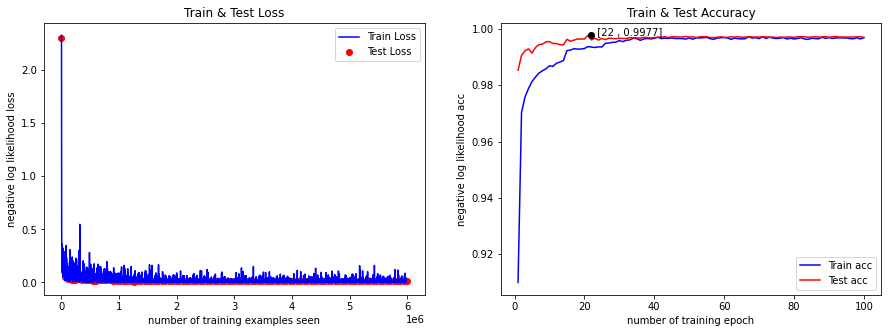

In [19]:
#可视化
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.title('Train & Test Loss')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

plt.subplot(122)

max_test_acces_epoch = test_acces.index(max(test_acces)) + 1
max_test_acces = round(max(test_acces),4)


plt.plot([epoch+1 for epoch in range(n_epochs) ], train_acces, color='blue')
plt.plot([epoch+1 for epoch in range(n_epochs) ], test_acces[1:], color='red')

plt.plot(max_test_acces_epoch,max_test_acces,'ko') #最大值点

show_max='  ['+str(max_test_acces_epoch )+' , '+str(max_test_acces)+']'
plt.annotate(show_max,xy=(max_test_acces_epoch,max_test_acces), 
             xytext=(max_test_acces_epoch,max_test_acces))

plt.legend(['Train acc', 'Test acc'], loc='lower right')
plt.title('Train & Test Accuracy')
#plt.ylim(0.8, 1)
plt.xlabel('number of training epoch')
plt.ylabel('negative log likelihood acc')
plt.show()

# 预测

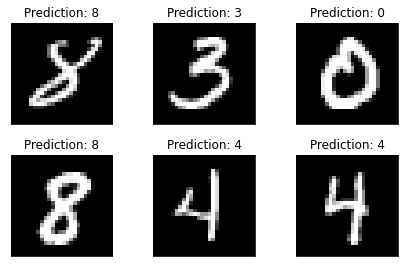

In [20]:
#预测
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(example)
with torch.no_grad():
    output = network(example_data.to(device))
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
        plt.title("Prediction: {}".format(
        output.data.max(1, keepdim=True)[1][i].item()))
        plt.xticks([])
        plt.yticks([])
    plt.show()

# 图片处理

In [68]:
#图片处理
def imageProcess(img):
    #处理图片
    data_transform = torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32),
         torchvision.transforms.CenterCrop(28),
         torchvision.transforms.ToTensor(),
         torchvision.transforms.Normalize((0.1307,), (0.3081,))])
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)# 灰度处理
    retval, dst = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)# 二值化
    fanse = cv2.bitwise_not(dst)#黑白反转

    #将BGR图像转变成RGB图像：即将cv2.imread转换成Image.open
    imgs = Image.fromarray(cv2.cvtColor(fanse, cv2.COLOR_BGR2RGB))
    imgs = imgs.convert('L') #将三通道图像转换成单通道灰度图像
    imgs = data_transform(imgs)#处理图像
    
    return imgs

# 加载模型

In [69]:
#加载模型
'''
network = CNNModel()


model_path = "./model03.pth"
network.load_state_dict(torch.load(model_path))
network.eval()
'''


'\nnetwork = CNNModel()\n\n\nmodel_path = "./model.pth"\nnetwork.load_state_dict(torch.load(model_path))\nnetwork.eval()\n'

# 预测手写数字

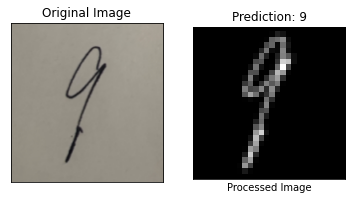

In [72]:
#预测手写数字
path = 'E:/jupyter_notebook/test/' #图片保存路径
with torch.no_grad():   
    img = cv2.imread(path + '9.jpg')#预测图片
    imgs = imageProcess(img)
    if imgs.shape == torch.Size([1,28,28]):
        imgs = torch.unsqueeze(imgs, dim=0) #在最前面增加一个维度
    output = network(imgs.to(device))
    plt.tight_layout()
    plt.subplot(121)
    img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.imshow(img)
    plt.title("Original Image")
    plt.xticks([])
    plt.yticks([])

    
    plt.subplot(122)
    plt.imshow(imgs[0][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(output.data.max(dim = 1, keepdim=True)[1].item()))
    plt.xlabel("Processed Image")
    plt.xticks([])
    plt.yticks([])
    plt.show()

# 调整参数优化模型

In [24]:
# 实例化一个网络
network = CNNModel()
#加载模型
model_path = "./model03.pth"
network.load_state_dict(torch.load(model_path))

network.to(device)


#network.apply(weights_init)
# 设置优化器，用stochastic gradient descent，设置学习率，设置momentum
#optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
#optimizer = optim.Adam(network.parameters(), lr=learning_rate,)
optimizer = optim.RMSprop(network.parameters(),lr=1e-8,alpha=0.99,momentum = momentum)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True, threshold=1e-8, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-12)


In [25]:
test(1)

 Test set 1 : Avg. loss: 0.0085, Accuracy: 9977/10000  (99.77%)


In [26]:
for epoch in range(101, 121):
    scheduler.step(test_losses[-1])
    train(epoch)
    test(epoch)
print('\n\033[1;31mThe network Max Avg Accuracy : {:.2f}%\033[0m'.format(100. * max(test_acces)))

 第 101 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.004242	Train Accuracy:99.43%
 Test set 101 : Avg. loss: 0.0088, Accuracy: 9974/10000  (99.74%)
 第 102 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.037284	Train Accuracy:99.41%
 Test set 102 : Avg. loss: 0.0087, Accuracy: 9974/10000  (99.74%)
 第 103 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.017901	Train Accuracy:99.40%
 Test set 103 : Avg. loss: 0.0086, Accuracy: 9974/10000  (99.74%)
 第 104 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.002881	Train Accuracy:99.46%
 Test set 104 : Avg. loss: 0.0087, Accuracy: 9974/10000  (99.74%)
Epoch     5: reducing learning rate of group 0 to 5.0000e-09.
 第 105 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.134821	Train Accuracy:99.41%
 Test set 105 : Avg. loss: 0.0087, Accuracy: 9974/10000  (99.74%)
 第 106 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.045981	Train Accuracy:99.42%
 Test set 106 : Avg. loss: 0.0089, Accuracy: 9973/10000  (99.73%)
 第 107 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.002419	Trai

In [28]:
#network.apply(weights_init)
# 设置优化器，用stochastic gradient descent，设置学习率，设置momentum
#optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
optimizer = optim.Adam(network.parameters(), lr=6.2500e-10,betas = (0.9,0.999))
#optimizer = optim.RMSprop(network.parameters(),lr=1e-8,alpha=0.99,momentum = momentum)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True, threshold=1e-11, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-13)


In [29]:
for epoch in range(121, 131):
    scheduler.step(train_acces[-1])
    train(epoch)
    test(epoch)
print('\n\033[1;31mThe network Max Avg Accuracy : {:.2f}%\033[0m'.format(100. * max(test_acces)))

 第 121 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.001601	Train Accuracy:99.41%
 Test set 121 : Avg. loss: 0.0088, Accuracy: 9974/10000  (99.74%)
 第 122 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.021223	Train Accuracy:99.35%
 Test set 122 : Avg. loss: 0.0087, Accuracy: 9973/10000  (99.73%)
 第 123 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.044774	Train Accuracy:99.38%
 Test set 123 : Avg. loss: 0.0087, Accuracy: 9974/10000  (99.74%)
 第 124 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.004756	Train Accuracy:99.38%
 Test set 124 : Avg. loss: 0.0087, Accuracy: 9974/10000  (99.74%)
Epoch     5: reducing learning rate of group 0 to 3.1250e-10.
 第 125 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.003860	Train Accuracy:99.42%
 Test set 125 : Avg. loss: 0.0088, Accuracy: 9973/10000  (99.73%)
 第 126 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.017023	Train Accuracy:99.38%
 Test set 126 : Avg. loss: 0.0089, Accuracy: 9975/10000  (99.75%)
 第 127 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.011459	Trai

In [30]:
#network.apply(weights_init)
# 设置优化器，用stochastic gradient descent，设置学习率，设置momentum
#optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
#optimizer = optim.Adam(network.parameters(), lr=6.2500e-10,betas = (0.9,0.999))
optimizer = optim.RMSprop(network.parameters(),lr=0.00001,alpha=0.99,momentum = momentum)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, verbose=True, threshold=1e-11, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-13)


In [31]:
for epoch in range(131, 141):
    scheduler.step(train_acces[-1])
    train(epoch)
    test(epoch)
print('\n\033[1;31mThe network Max Avg Accuracy : {:.2f}%\033[0m'.format(100. * max(test_acces)))

 第 131 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.003080	Train Accuracy:99.42%
 Test set 131 : Avg. loss: 0.0083, Accuracy: 9970/10000  (99.70%)
 第 132 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.000917	Train Accuracy:99.45%
 Test set 132 : Avg. loss: 0.0081, Accuracy: 9972/10000  (99.72%)
 第 133 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.001062	Train Accuracy:99.46%
 Test set 133 : Avg. loss: 0.0080, Accuracy: 9973/10000  (99.73%)
 第 134 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.016152	Train Accuracy:99.47%
 Test set 134 : Avg. loss: 0.0081, Accuracy: 9973/10000  (99.73%)
 第 135 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.007471	Train Accuracy:99.52%
 Test set 135 : Avg. loss: 0.0080, Accuracy: 9974/10000  (99.74%)
 第 136 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.002802	Train Accuracy:99.55%
 Test set 136 : Avg. loss: 0.0083, Accuracy: 9975/10000  (99.75%)
 第 137 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.007342	Train Accuracy:99.49%
 Test set 137 : Avg. loss: 0.0082, Accuracy:

In [33]:
#network.apply(weights_init)
# 设置优化器，用stochastic gradient descent，设置学习率，设置momentum
#optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
#optimizer = optim.Adam(network.parameters(), lr=6.2500e-10,betas = (0.9,0.999))
optimizer = optim.RMSprop(network.parameters(),lr=0.00001,alpha=0.99,momentum = momentum)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, verbose=True, threshold=1e-11, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-13)


In [34]:
for epoch in range(141, 151):
    scheduler.step(train_acces[-1])
    train(epoch)
    test(epoch)
print('\n\033[1;31mThe network Max Avg Accuracy : {:.2f}%\033[0m'.format(100. * max(test_acces)))

 第 141 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.003045	Train Accuracy:99.46%
 Test set 141 : Avg. loss: 0.0085, Accuracy: 9976/10000  (99.76%)
 第 142 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.000480	Train Accuracy:99.41%
 Test set 142 : Avg. loss: 0.0084, Accuracy: 9975/10000  (99.75%)
Epoch     3: reducing learning rate of group 0 to 5.0000e-06.
 第 143 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.031258	Train Accuracy:99.43%
 Test set 143 : Avg. loss: 0.0083, Accuracy: 9975/10000  (99.75%)
 第 144 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.044489	Train Accuracy:99.46%
 Test set 144 : Avg. loss: 0.0084, Accuracy: 9974/10000  (99.74%)
Epoch     5: reducing learning rate of group 0 to 2.5000e-06.
 第 145 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.028560	Train Accuracy:99.43%
 Test set 145 : Avg. loss: 0.0084, Accuracy: 9976/10000  (99.76%)
 第 146 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.020809	Train Accuracy:99.48%
 Test set 146 : Avg. loss: 0.0085, Accuracy: 9976/10000  (99.76%)


In [61]:
# 实例化一个网络
network = CNNModel()
#加载模型
model_path = "./model03.pth"
network.load_state_dict(torch.load(model_path))

network.to(device)
test(1)

 Test set 1 : Avg. loss: 0.0084, Accuracy: 9977/10000  (99.77%)
